# WhatsApp Sport tournament Stats

In [509]:
import os
import re
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [510]:
file_path = "C:/Users/david/Documents/Projects/WhatsApp Bot/WhatsAppBot/data/Chat de WhatsApp con Family Deporte.txt"
participants = {
    'David',
    'Adri',
    'Adrian',
    'Carmen',
    'Diego',
    'Ivette',
    'Patricio',
    'Ramón',
    'Sam',
    'Santiago',
    'Vannesa'
}
dir_indicator = "family_deporte"

In [511]:
# file_path = "C:/Users/david/Documents/Projects/WhatsApp Bot/WhatsAppBot/data/Chat de WhatsApp con Torneo Saiyajin.txt"
# participants = {
#     'David',
#     'Alejandro',
#     'Andrea',
#     'Chirino',
#     'Emiliano',
#     'Fernando',
#     'Armando',
#     'Octavio',
#     'Ricardo',
#     'Uriel',
#     'Sara',
#     'Tupac',
#     'Mathilde',
#     'Capucine',
#     'Tania',
# }
# dir_indicator = "sport_avec_potes"

In [512]:
week = 1

## Raw Data

In [513]:
# read txt file
with open(file_path, 'r', encoding='utf-8') as file:
    raw_data = file.readlines()


# from pprint import pprint
# pprint(raw_data)

## Data Extraction

In [514]:
results = []
current_entry = None

# pattern to match the start of a WhatsApp message
start_pattern = re.compile(r"^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}) - (.*?): (.*)")
points_pattern = re.compile(r"^(.+?)\s*:\s*(\d+)$")  # pattern for lines with name: points

for line in raw_data:
    line = line.replace('\xa0', ' ').strip()

    start_match = start_pattern.match(line)

    if start_match:
        # new message: extract date, time, author
        date_str, time_str, author, content = start_match.groups()
        timestamp = datetime.strptime(f"{date_str} {time_str}", "%d/%m/%Y %H:%M")

        current_entry = {
            "timestamp": timestamp,
            "author": author,
            "points": {}
        }
        results.append(current_entry)

        # check if message content itself is a points entry
        inline_points = points_pattern.match(content)
        if inline_points:
            name, pts = inline_points.groups()
            if name in participants:
                current_entry["points"][name] = int(pts)

    elif current_entry:
        # check for additional lines with name: points
        point_match = points_pattern.match(line)
        if point_match:
            name, pts = point_match.groups()
            if name in participants:
                current_entry["points"][name] = int(pts)



In [515]:
# results

## Format Data

In [516]:
# create a list of rows, each row is a dict with timestamp + points
rows = []

for entry in results:
    row = {"timestamp": entry["timestamp"]}
    row.update(entry["points"])
    rows.append(row)

# create the dataframe
df = pd.DataFrame(rows)

# optionally, sort by timestamp
df = df.sort_values("timestamp").reset_index(drop=True)

# clean empty rows
df = df.dropna(subset=df.columns[1:], how='all')

# convert to int
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# show the dataframe
# print(df)


## Points by day

In [517]:
# extract the date (year-month-day) from timestamp
df["date"] = df["timestamp"].dt.date

# group by date and get max points per participant
daily_points = df.groupby("date").max(numeric_only=True).reset_index()

# create full date range from min to max date
full_range = pd.date_range(start=daily_points["date"].min(), end=daily_points["date"].max(), freq="D")

# reindex the dataframe to include all days
daily_points = daily_points.set_index("date").reindex(full_range).rename_axis("date").reset_index()

# fill missing dates with previous values
daily_points = daily_points.fillna(method='ffill')

# add day name (e.g., Monday, Tuesday)
daily_points["day"] = pd.to_datetime(daily_points["date"]).dt.day_name()

# reorder columns to have day first (optional)
cols = ["date", "day"] + [col for col in daily_points.columns if col not in ["date", "day"]]
daily_points = daily_points[cols]

# show the daily summary
display(daily_points)


C:\Users\david\AppData\Local\Temp\ipykernel_16492\678930988.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_points = daily_points.fillna(method='ffill')


,date,day,David,Adri,Adrian,Carmen,Diego,Ivette,Patricio,Ramón,Sam,Santiago,Vannesa
0,2025-07-21,Monday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-07-22,Tuesday,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2,2025-07-23,Wednesday,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0
3,2025-07-24,Thursday,3.0,3.0,0.0,0.0,0.0,2.0,3.0,3.0,3.0,2.0,1.0
4,2025-07-25,Friday,3.0,4.0,0.0,0.0,1.0,2.0,4.0,4.0,4.0,2.0,1.0
5,2025-07-26,Saturday,4.0,4.0,0.0,0.0,1.0,3.0,4.0,4.0,4.0,3.0,3.0
6,2025-07-27,Sunday,4.0,4.0,0.0,0.0,1.0,3.0,4.0,4.0,4.0,3.0,3.0
7,2025-07-28,Monday,5.0,4.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,4.0,3.0
8,2025-07-29,Tuesday,6.0,4.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,4.0,3.0


## Points by week

In [518]:
# ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# group by week starting on Monday and get max points per participant per week
weekly_points = (
    df.set_index("timestamp")
      .groupby(pd.Grouper(freq="W-SUN"))
      .max(numeric_only=True)
      .reset_index()
)

# rename timestamp to week_start
weekly_points.rename(columns={"timestamp": "week_end"}, inplace=True)

# add a week number column starting at 1
weekly_points["week_number"] = range(1, len(weekly_points) + 1)

# reorder columns to have week_number first (optional)
cols = ["week_number", "week_end"] + [col for col in weekly_points.columns if col not in ["week_number", "week_end"]]
weekly_points = weekly_points[cols]

display(weekly_points)

,week_number,week_end,David,Adri,Adrian,Carmen,Diego,Ivette,Patricio,Ramón,Sam,Santiago,Vannesa
0,1,2025-07-27,4,4,0,0,1,3,4,4,4,3,3
1,2,2025-08-03,6,4,0,0,1,4,4,4,5,4,3


## Export Stats

In [519]:
# create week directory if it doesn't exist
week_dir = f"data/week_{week}/{dir_indicator}"
if not os.path.exists(week_dir):
    os.makedirs(week_dir)

### Total points for current week

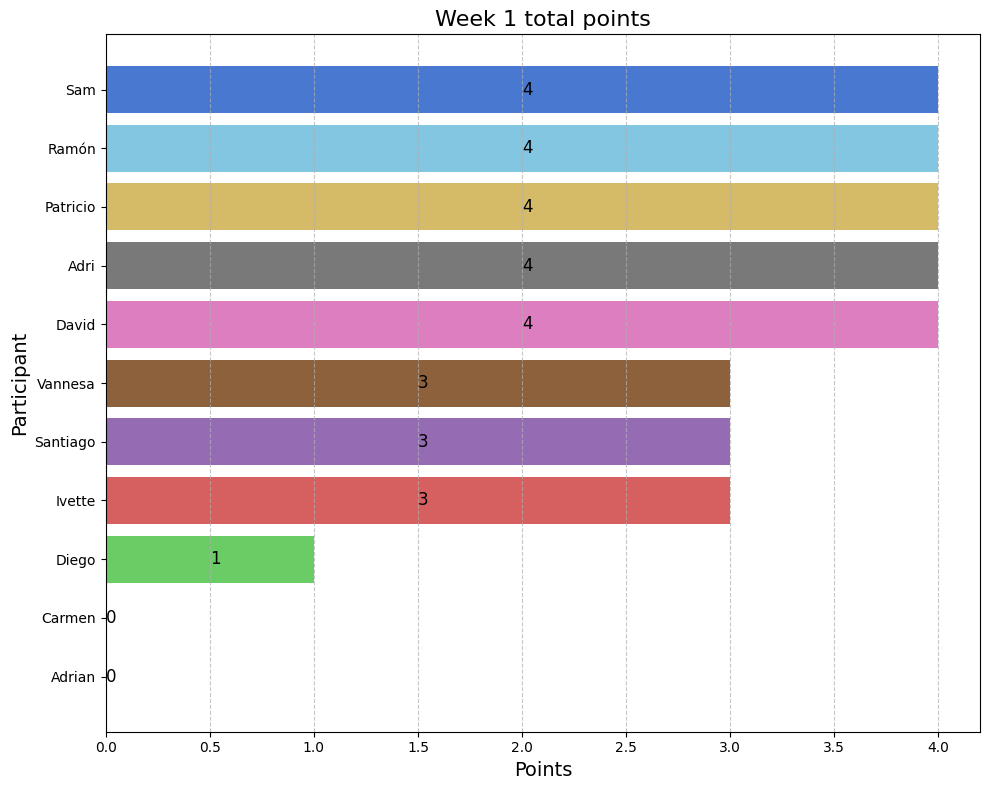

In [520]:
# get max points per participant and sort ascending for horizontal bar plot
current_week_data = weekly_points[weekly_points.week_number == week].drop(columns=["week_end", "week_number"])
max_points = current_week_data.max()
max_points_sorted = max_points.sort_values(ascending=True)

# compute delta from previous week if available
if week > 1:
    prev_week_data = weekly_points[weekly_points.week_number == (week - 1)].drop(columns=["week_end", "week_number"])
    prev_points = prev_week_data.max()
    deltas = max_points - prev_points
else:
    deltas = max_points.copy()
    deltas[:] = 0  # no delta for the first week

# use a softer color palette
palette = sns.color_palette("muted", len(max_points_sorted))

plt.figure(figsize=(10, 8))
bars = plt.barh(max_points_sorted.index, max_points_sorted.values, color=palette)

# add label to each bar: "total (+delta)"
for i, bar in enumerate(bars):
    name = max_points_sorted.index[i]
    total = bar.get_width()
    delta = deltas[name]
    
    # format label with delta if not first week
    if week > 1:
        label = f"{int(total)} (+{int(delta)})"
    else:
        label = f"{int(total)}"
    
    plt.text(
        total / 2,
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        ha='left',
        fontsize=12,
        color='black'
    )

plt.title(f"Week {week} total points", fontsize=16)
plt.xlabel("Points", fontsize=14)
plt.ylabel("Participant", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

# export to image
plt.savefig(f"{week_dir}/week_{week}_total_points.png")

plt.show()
plt.close()

### Points per Day for week X

In [521]:
# get the end date of the selected week
week_row = weekly_points[weekly_points["week_number"] == week]
if week_row.empty:
    print(f"Week {week} not found.")
else:
    week_end = pd.to_datetime(week_row["week_end"].values[0])
    week_start = week_end - pd.Timedelta(days=6)

    # filter daily data for the selected week
    mask = (pd.to_datetime(daily_points["date"]) >= week_start) & (pd.to_datetime(daily_points["date"]) <= week_end)
    week_data = daily_points.loc[mask].copy()

    if week_data.empty:
        print(f"No daily data found for week {week}.")
    else:
        # add a column with the name of the day
        week_data["day"] = pd.to_datetime(week_data["date"]).dt.day_name()

        # reorder columns: date, day, participants
        cols = ["date", "day"] + [c for c in week_data.columns if c not in ["date", "day"]]
        week_data = week_data[cols]

        # convert to int
        for col in week_data.columns[2:]:
            week_data[col] = pd.to_numeric(week_data[col], errors='coerce').fillna(0).astype(int)

        # remove hours from date
        week_data["date"] = pd.to_datetime(week_data["date"]).dt.date

        # print table to console
        print(week_data)

        # export table as image
        plt.figure(figsize=(len(participants) + 4, 0.5 + len(week_data) * 0.4))
        plt.axis('off')
        table = plt.table(
            cellText=week_data.values,
            colLabels=week_data.columns,
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)

        # save image
        output_path = f"{week_dir}/week_{week}_daily_table.png"
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()
        print(f"Saved table to {output_path}")


         date        day  David  Adri  Adrian  Carmen  Diego  Ivette  \
0  2025-07-21     Monday      0     0       0       0      0       0   
1  2025-07-22    Tuesday      1     1       0       0      0       0   
2  2025-07-23  Wednesday      2     2       0       0      0       2   
3  2025-07-24   Thursday      3     3       0       0      0       2   
4  2025-07-25     Friday      3     4       0       0      1       2   
5  2025-07-26   Saturday      4     4       0       0      1       3   
6  2025-07-27     Sunday      4     4       0       0      1       3   

   Patricio  Ramón  Sam  Santiago  Vannesa  
0         0      0    0         0        0  
1         1      1    1         1        0  
2         2      2    2         1        1  
3         3      3    3         2        1  
4         4      4    4         2        1  
5         4      4    4         3        3  
6         4      4    4         3        3  
Saved table to data/week_1/family_deporte/week_1_daily_table.pn